# <b> <div style='padding:25px;background-color:#9B2335;color:white;border-radius:4px;font-size:100%;text-align: center'>Singapore  Resale Flat Prices Prediction<br> </div>

## <p style="color:Khaki;"> Importing required libraries</p>

In [22]:
import pandas as pd
pd.set_option("display.precision", 4)
pd.set_option('display.float_format', '{:.4f}'.format)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr,kstest, norm, skew,kurtosis, boxcox
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import pickle
import os

sns.set_theme(context='notebook', style='white', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style({'axes.facecolor': 'white','axes.edgecolor': 'white'})

color_good = '\033[32m'   # Dark Green for near-zero skew
color_okay = '\033[92m'   # Light Green for slightly positive or slightly negative skew
color_bad = '\033[91m'    # Maroon for significant skew
color_neutral = '\033[0m' # Reset color


In [9]:
import EDA_Before

In [10]:
df1=pd.read_feather('df_outlier.feather')

In [11]:
df1.sample(5)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year
59844,1,Queenstown,4 Room,88.0000,Improved,1976,182000.0000,3,12,1994,23 Dover Cres Queenstown,2068.1818,81
103155,10,Bukit Merah,3 Room,65.0000,Improved,1975,129000.0000,3,6,1995,15 Telok Blangah Cres Bukit Merah,1984.6154,79
103842,10,Jurong East,5 Room,117.0000,Standard,1979,337000.0000,3,15,1995,405 Pandan Gdns Jurong East,2880.3419,83
118788,5,Clementi,4 Room,97.0000,New Generation,1978,282000.0000,3,9,2003,410 C'Wealth Ave West Clementi,2907.2165,74
44997,4,Hougang,5 Room,120.0000,Improved,1987,347000.0000,3,3,2001,641 Hougang Ave 8 Hougang,2891.6667,85


## <p Style="color: Khaki"> Data Transformation:

### <p Style="color: Khaki">Experimenting with a few types of data transformation techniques to see which one suits best.

#### <p Style="color: Aqua"> Defining a function to perform Box-Cox and Applying

In [12]:
def boxcox_transform(x):
    transformed_data,lmbda = boxcox(x)
    return transformed_data,lmbda

In [13]:
method_functions =  {
    'log': np.log,
    'square': np.sqrt,
    'rec': lambda x: 1 / x,
    'sig': lambda x: 1 / (1 + np.exp(-x)),
    'pow': lambda x: np.power(x, 2),
    'exp':lambda x: x**(1/5),
    'boxcox': boxcox_transform,
        }

def skewness_checker(df, column, method):
    normalized_df=pd.DataFrame()

    for method_name, func in method_functions.items():
        for col in column:

            new_column = f'{col}_{method_name}'
            if method_name in ['boxcox']:
                transformed_values = func(df[col])[0]
            else:
                transformed_values = func(df[col])
            normalized_df[new_column] = transformed_values

    return normalized_df

#### <p Style="color: Aqua"> Created a new Data Frame that contains transformed values:

In [14]:
normalized_df=skewness_checker(df1, ['floor_area_sqm','resale_price'], method_functions)
normalized_df.sample(5)

,floor_area_sqm_log,resale_price_log,floor_area_sqm_square,resale_price_square,floor_area_sqm_rec,resale_price_rec,floor_area_sqm_sig,resale_price_sig,floor_area_sqm_pow,resale_price_pow,floor_area_sqm_exp,resale_price_exp,floor_area_sqm_boxcox,resale_price_boxcox
179765,4.8203,12.5245,11.1355,524.4044,0.0081,0.0000,1.0000,1.0000,15376.0000,75625000000.0000,2.6223,12.2424,13.2119,1024.5815
271332,4.8203,12.7657,11.1355,591.6080,0.0081,0.0000,1.0000,1.0000,15376.0000,122500000000.0000,2.6223,12.8474,13.2119,1155.5728
229357,4.8598,12.6115,11.3578,547.7226,0.0078,0.0000,1.0000,1.0000,16641.0000,90000000000.0000,2.6431,12.4573,13.4442,1070.0399
102877,4.7274,13.3503,10.6301,792.4645,0.0088,0.0000,1.0000,1.0000,12769.0000,394384000000.0000,2.5740,14.4408,12.6790,1546.7387
115055,4.5850,12.9116,9.8995,636.3961,0.0102,0.0000,1.0000,1.0000,9604.0000,164025000000.0000,2.5018,13.2279,11.8965,1242.8385


#### <p Style="color: Aqua"> Plotting all type of transformed values:

In [18]:
import EDA_Before
from EDA_Before import univar_num

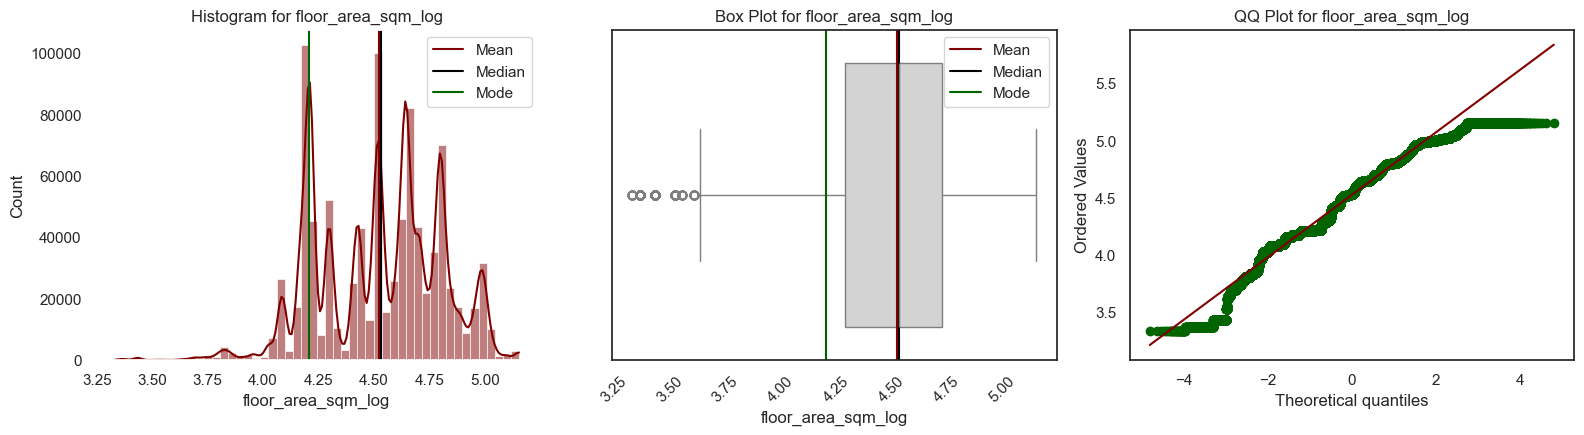



Skew for floor_area_sqm_log is -0.24

Kurtosis for floor_area_sqm_log is -0.38




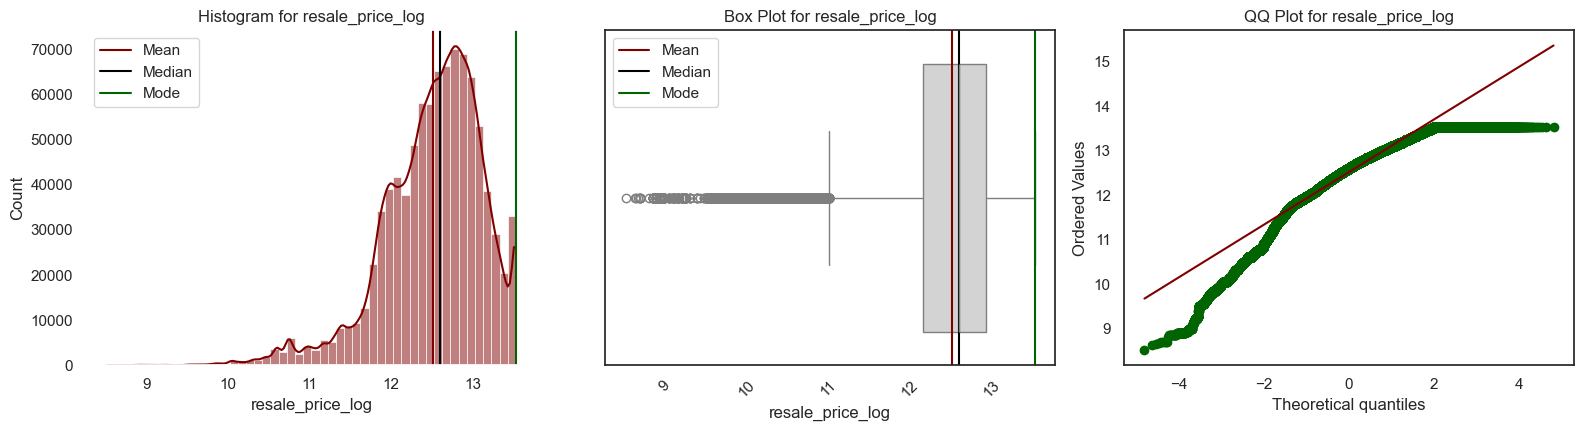



Skew for resale_price_log is -0.98

Kurtosis for resale_price_log is 1.62




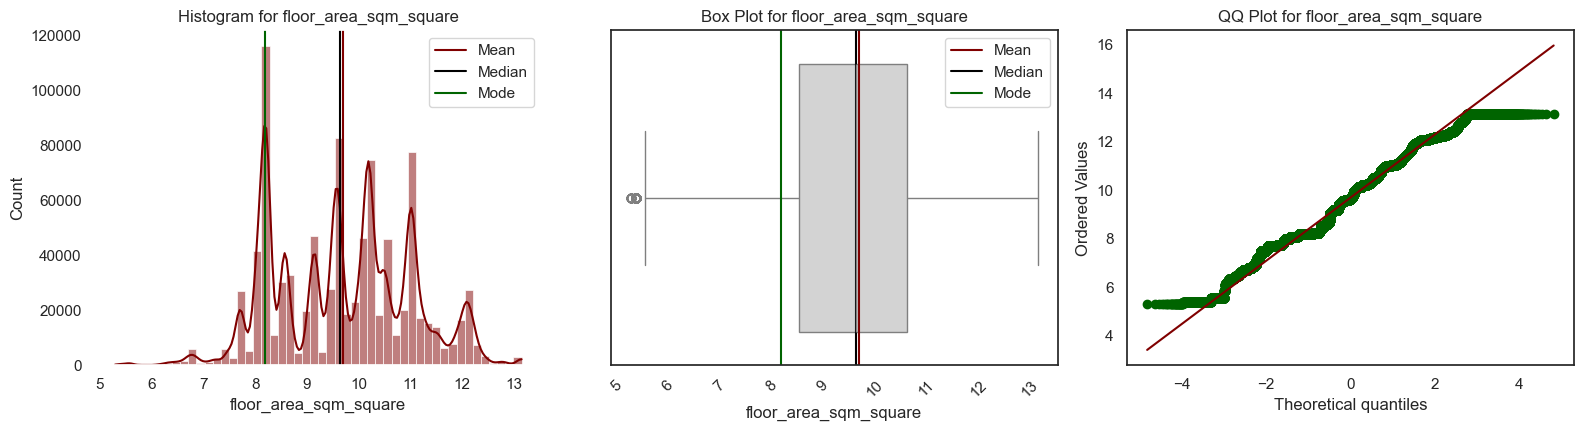



Skew for floor_area_sqm_square is 0.06

Kurtosis for floor_area_sqm_square is -0.63




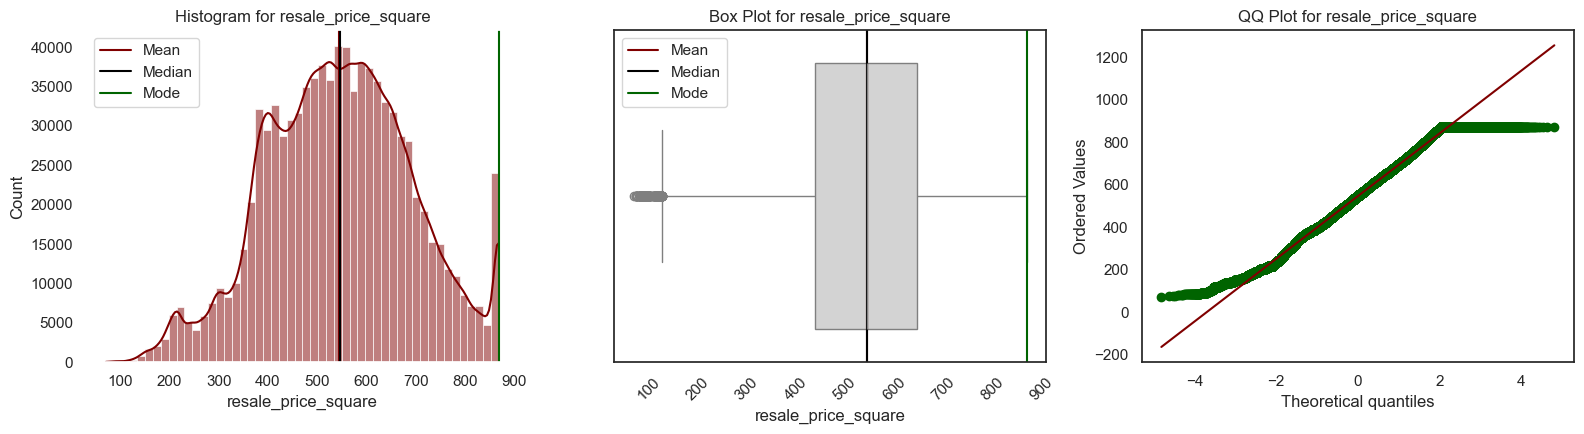



Skew for resale_price_square is -0.02

Kurtosis for resale_price_square is -0.27




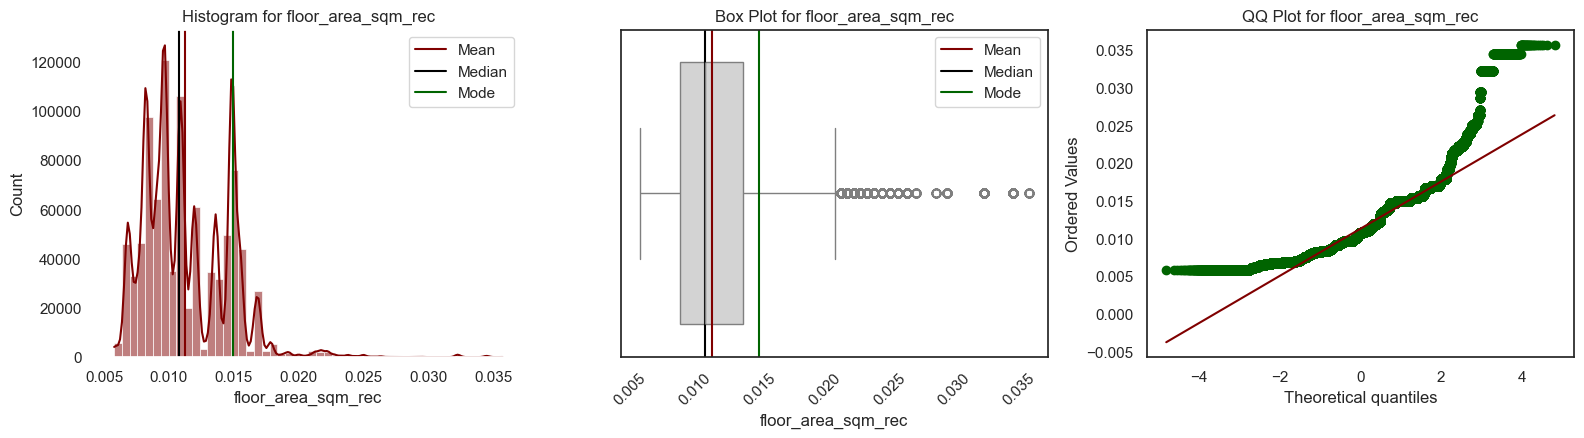



Skew for floor_area_sqm_rec is 1.11

Kurtosis for floor_area_sqm_rec is 3.01




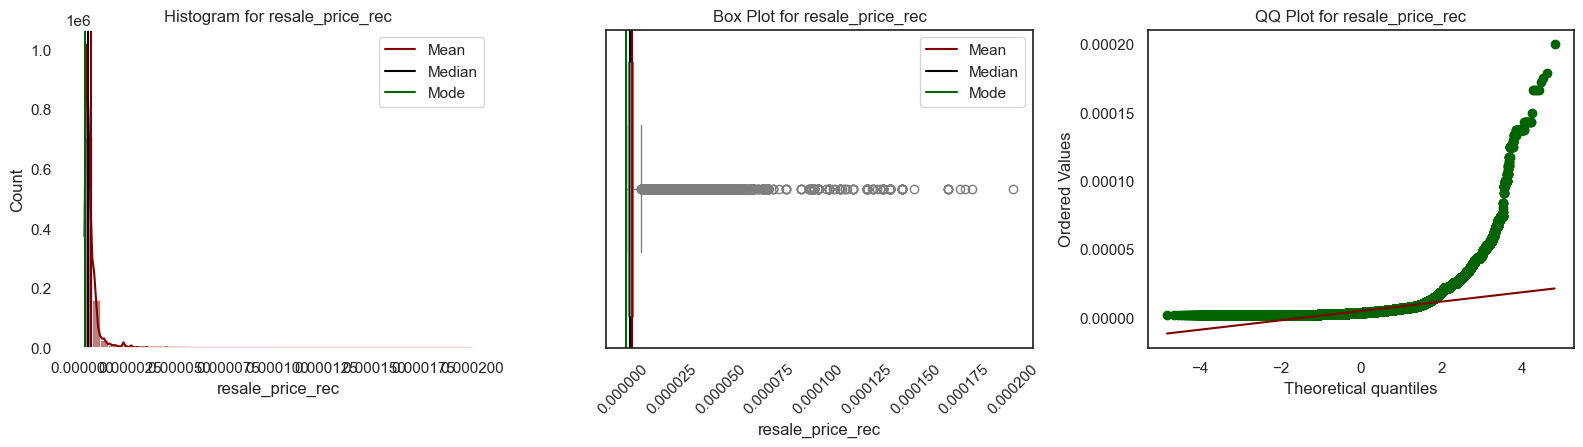



Skew for resale_price_rec is 7.25

Kurtosis for resale_price_rec is 112.60




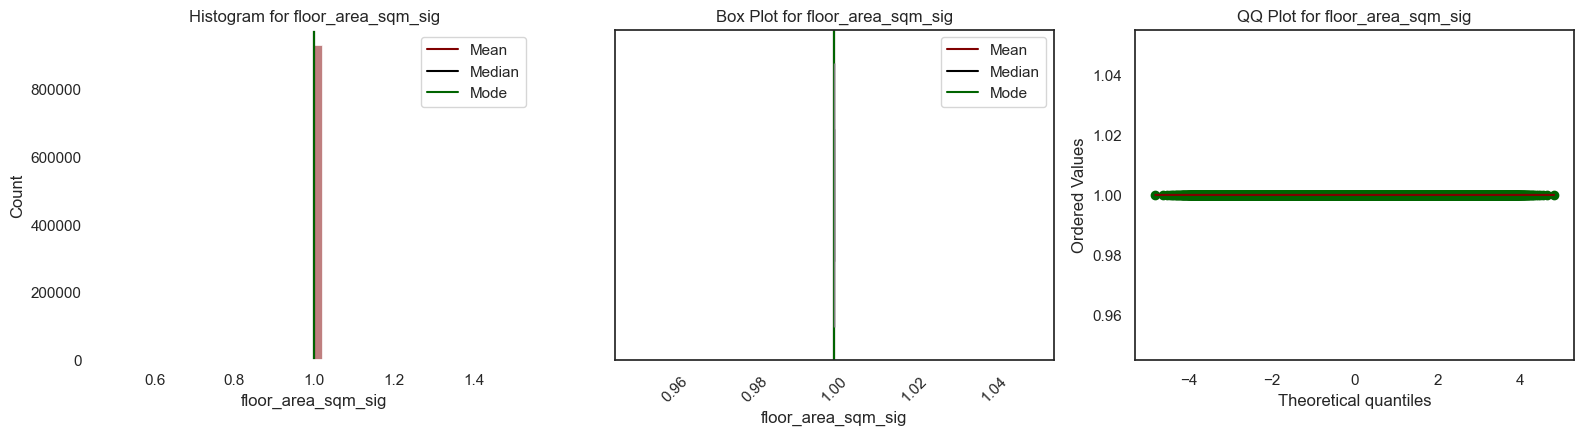



Skew for floor_area_sqm_sig is 0.00

Kurtosis for floor_area_sqm_sig is 0.00




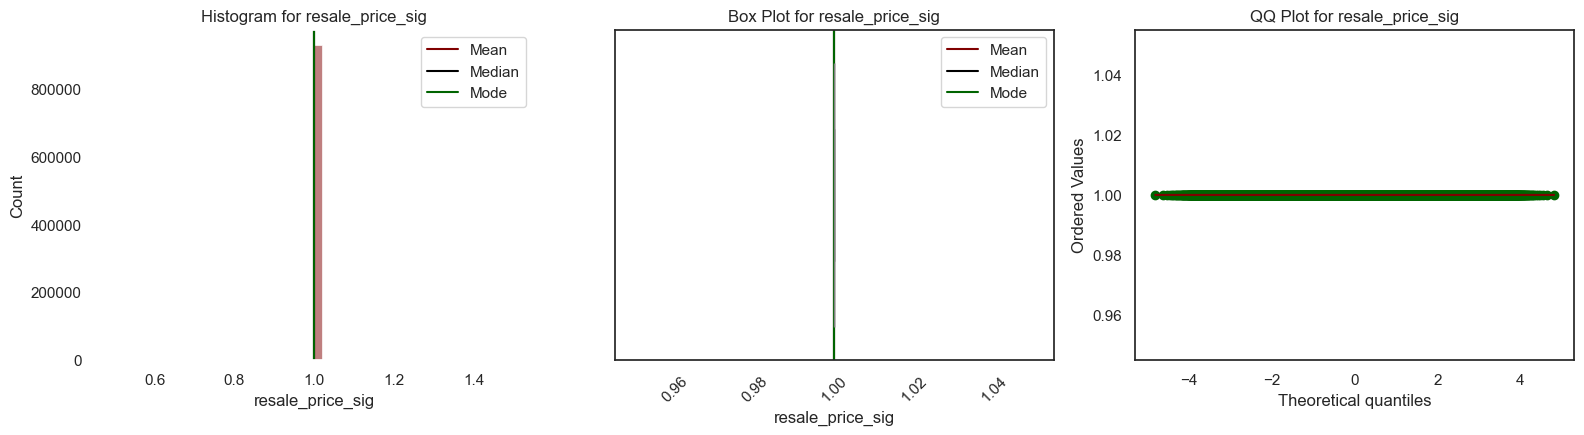



Skew for resale_price_sig is 0.00

Kurtosis for resale_price_sig is 0.00




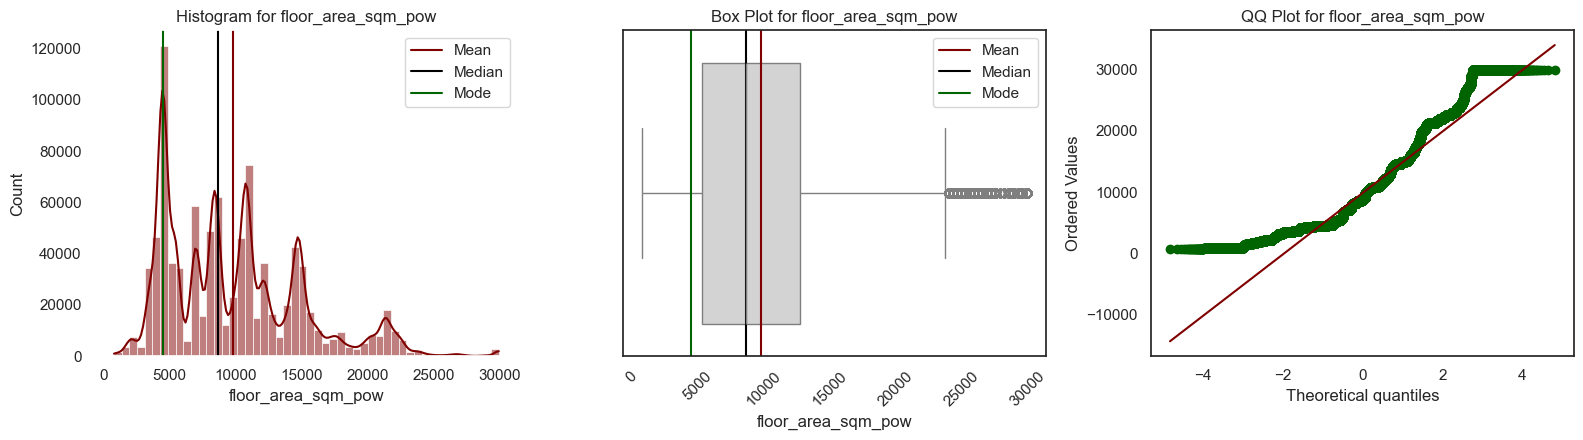



Skew for floor_area_sqm_pow is 0.87

Kurtosis for floor_area_sqm_pow is 0.43




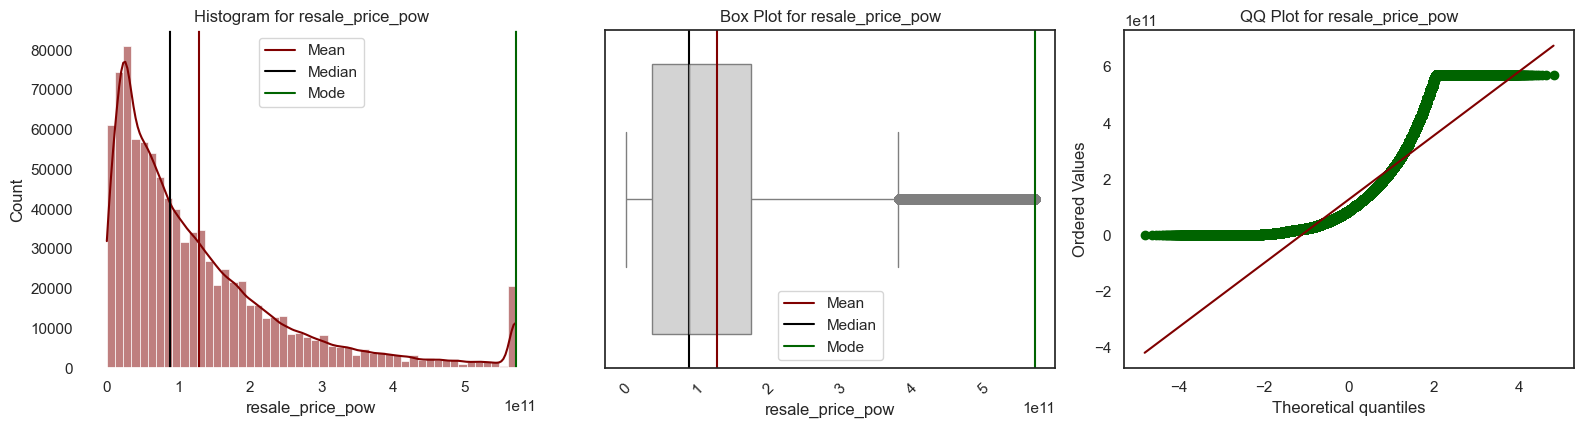



Skew for resale_price_pow is 1.70

Kurtosis for resale_price_pow is 2.81




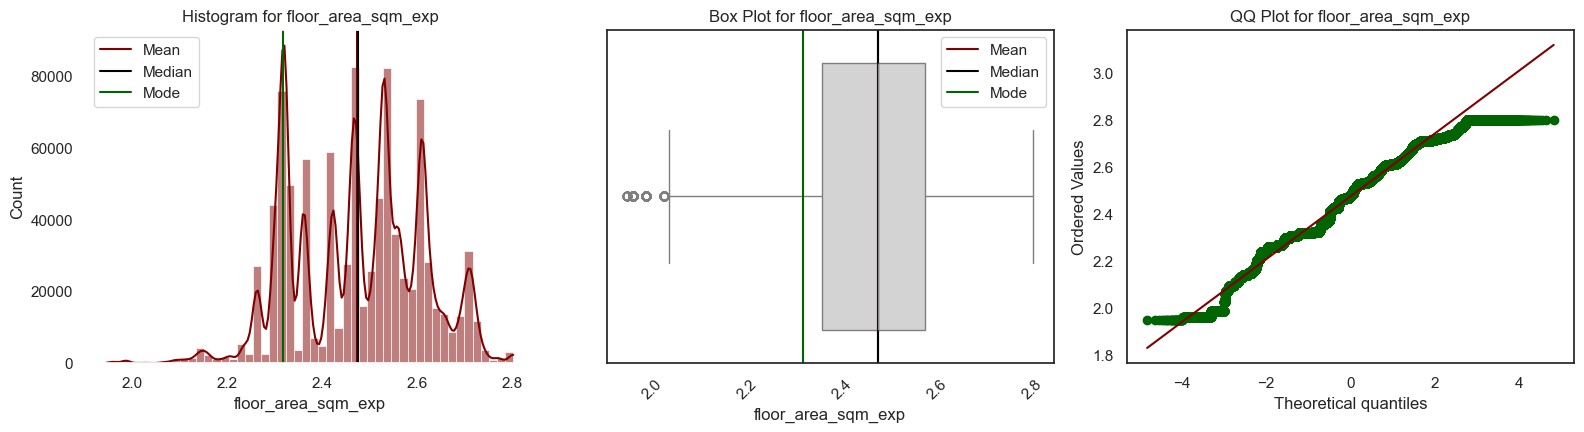



Skew for floor_area_sqm_exp is -0.12

Kurtosis for floor_area_sqm_exp is -0.54




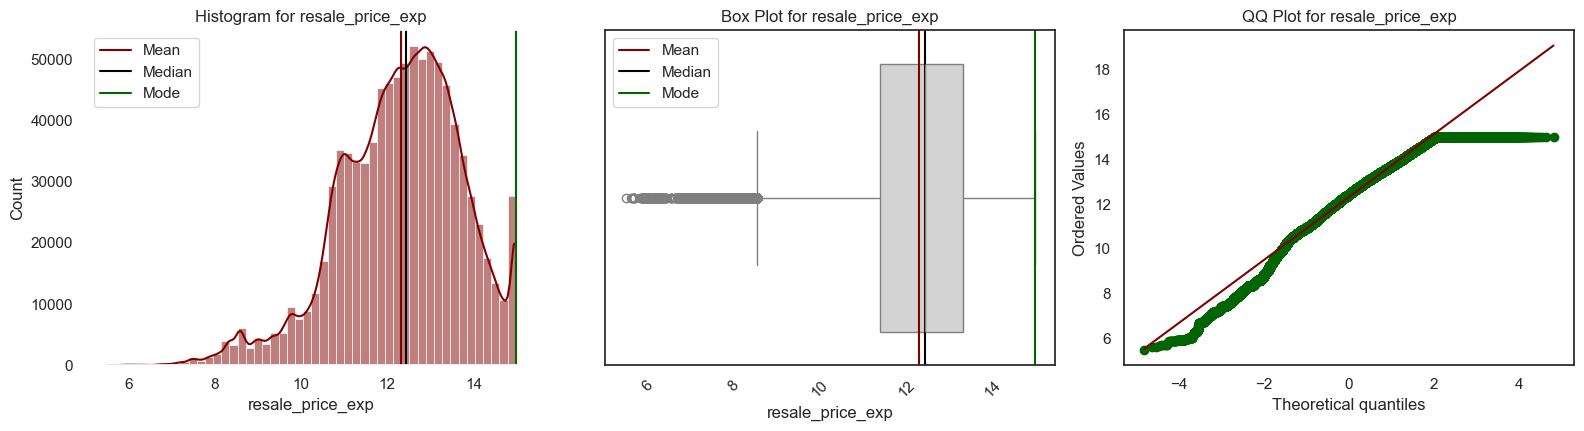



Skew for resale_price_exp is -0.54

Kurtosis for resale_price_exp is 0.41




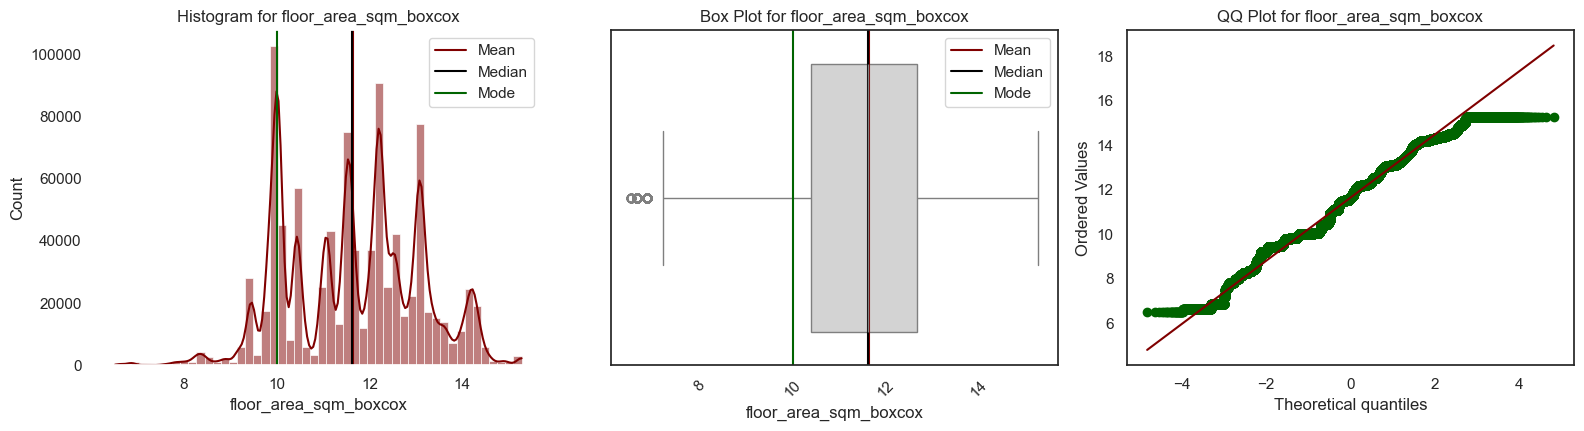



Skew for floor_area_sqm_boxcox is -0.02

Kurtosis for floor_area_sqm_boxcox is -0.61




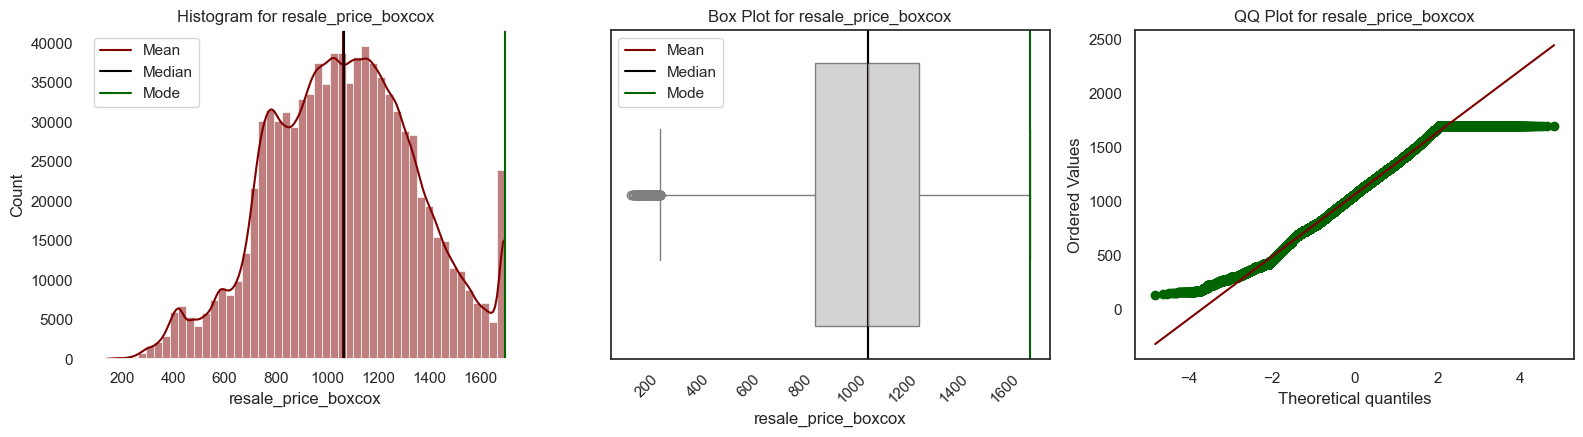



Skew for resale_price_boxcox is -0.03

Kurtosis for resale_price_boxcox is -0.27


Skewness:
 {'floor_area_sqm_log': -0.24312465, 'resale_price_log': -0.9802084975479526, 'floor_area_sqm_square': 0.056828357, 'resale_price_square': -0.02445505205925558, 'floor_area_sqm_rec': 1.1067953, 'resale_price_rec': 7.252767996839747, 'floor_area_sqm_sig': 0.0, 'resale_price_sig': 0.0, 'floor_area_sqm_pow': 0.87234503, 'resale_price_pow': 1.6968844179930338, 'floor_area_sqm_exp': -0.11821865, 'resale_price_exp': -0.544150912076482, 'floor_area_sqm_boxcox': -0.019980786, 'resale_price_boxcox': -0.027590538479159266} 

 Kurtois:
 {'floor_area_sqm_log': -0.37983075, 'resale_price_log': 1.6246860412703312, 'floor_area_sqm_square': -0.63135505, 'resale_price_square': -0.2679232016740425, 'floor_area_sqm_rec': 3.0069296, 'resale_price_rec': 112.60017608922038, 'floor_area_sqm_sig': 0.0, 'resale_price_sig': 0.0, 'floor_area_sqm_pow': 0.4287352, 'resale_price_pow': 2.807028776480553, 'floor_area_sqm_ex

In [19]:
transformed_skewness = {}
transformed_kurtosis = {}
for i in normalized_df.columns:
    univar_num(normalized_df,i)
    skews=normalized_df[i].skew()
    kurt=normalized_df[i].kurtosis()
    transformed_skewness.update({i:skews})
    transformed_kurtosis.update({i:kurt})
    color = color_neutral
    if -0.5 <= skews <= 0.5:
        color = color_good  # Dark Green for near-zero skew
    elif 0 < skews <= 0.5 or -0.5 < skews < 0:
        color = color_okay  # Light Green for slightly positive or slightly negative skew
    else:  # skew_val > 0.5 or skew_val < -0.5
        color = color_bad  # Maroon for significant skew
      
    print(f"\n\n{color}Skew for {i} is {skews:.2f}{color_neutral}")    
    print(f"\n{color}Kurtosis for {i} is {kurt:.2f}{color_neutral}\n\n")
print( 'Skewness:\n',transformed_skewness,'\n\n','Kurtois:\n',transformed_kurtosis)


<span style="color: Chartreuse;font-size:150%">   &#9784; </span> <span style="color: Tomato;font-size: 120%;background-color:"> <b> Based on the skewness and kurtosis values, the <span Style="color:Aqua"> Box-Cox transformation </span>is the best choice for addressing outliers and normalizing the distributions of both floor_area_sqm and resale_price. This should improve the performance of your predictive models.</b></span>

### <p Style="color: Khaki"> Applying Box-Cox transformation to our data and pickling:

In [23]:
lambda_dict = {}

df1['resale_price_boxcox'] , lambda_dict['resale_price_lambda'] = boxcox_transform(df1['resale_price'] +1)
df1['floor_area_boxcox'] , lambda_dict['floor_area_lambda'] = boxcox_transform(df1['floor_area_sqm'] +1)

os.makedirs('pkls', exist_ok=True)

with open(r'pkls/boxcox_lambdas.pkl', 'wb') as f:
    pickle.dump(lambda_dict, f)

In [24]:
df1.sample(6)

,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,floors,floor_no,year,full_address,price_per_sqm,remaining_lease_year,resale_price_boxcox,floor_area_boxcox
42433,1,Central Area,3 Room,56.0000,Standard,1974,340000.0000,3,6,2019,9 Selegie Rd Central Area,6071.4286,54,1138.9531,9.1235
150456,2,Kallang/Whampoa,5 Room,117.0000,Standard,1974,430000.0000,3,9,1997,56 Geylang Bahru Kallang/Whampoa,3675.2137,76,1280.4927,12.6851
182020,2,Bukit Batok,Executive,150.0000,Maisonette,1985,485000.0000,3,9,1998,125 Bt Batok Ctrl Bukit Batok,3233.3333,86,1359.7116,14.1197
81273,3,Tampines,5 Room,121.0000,Improved,1984,330000.0000,3,9,2002,804 Tampines Ave 4 Tampines,2727.2727,81,1122.1174,12.8717
205181,4,Queenstown,3 Room,65.0000,Improved,1976,190000.0000,3,9,2006,5 Ghim Moh Rd Queenstown,2923.0769,69,851.9248,9.7681
243280,9,Clementi,4 Room,90.0000,New Generation,1979,225000.0000,3,3,2007,354 Clementi Ave 2 Clementi,2500.0000,71,926.9334,11.3051


In [25]:
df1.to_feather('data_trans.feather')